In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier    
        
# Should use this class to generate CIFAR fig..
class LifelongForest:
    """
    Lifelong Forest class.
    """
    def __init__(self, acorn=None):
        """
        Two major things the Forest Class needs access to:
            1) the realized random forest model (self.models_ is a list of forests, 1 for each task)
            2) old data (to update posteriors when a new task is introduced)
        """
        self.models_ = []
        self.X_ = []
        self.y_ = []
        self.n_tasks = 0
        self.labels = set()
        
        if acorn is not None:
            np.random.seed(acorn)
    
    def new_forest(self, X, y, n_estimators=200, max_samples=0.32,
                        bootstrap=True, max_depth=30, min_samples_leaf=1,
                        acorn=None):
        """
        Input
        X: an array-like object of features; X.shape == (n_samples, n_features)
        y: an array-like object of class labels; len(y) == n_samples
        n_estimators: int; number of trees to construct (default = 200)
        max_samples: float in (0, 1]: number of samples to consider when 
            constructing a new tree (default = 0.32)
        bootstrap: bool; If True then the samples are sampled with replacement
        max_depth: int; maximum depth of a tree
        min_samples_leaf: int; minimum number of samples in a leaf node
        
        Return
        model: a BaggingClassifier fit to X, y
        """
        
        if X.ndim == 1:
            raise ValueError('1d data will cause headaches down the road')
            
        if acorn is not None:
            np.random.seed(acorn)
            
        self.X_.append(X)
        self.y_.append(y)
            
        
        max_features = int(np.ceil(np.sqrt(X.shape[1])))

        model=BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                                         max_features = max_features),
                                  n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  bootstrap=bootstrap)

        model.fit(X, y)
        self.models_.append(model)
        self.n_tasks += 1
        #changed to accommodate different number of classes for each predictor
        self.labels |=set(y)
        
        return model
    
 
    
    def _get_leaves(self, estimator):
        """
        Internal function to get leaf node ids of estimator.
        
        Input
        estimator: a fit DecisionTreeClassifier
        
        Return
        leaf_ids: numpy array; an array of leaf node ids
        
        Usage
        _estimate_posteriors(..)
        """
        
        # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left
        children_right = estimator.tree_.children_right
        feature = estimator.tree_.feature
        threshold = estimator.tree_.threshold

        leaf_ids = []
        stack = [(0, -1)] 
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()

            # If we have a test node
            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                leaf_ids.append(node_id)

        return np.array(leaf_ids)
    
    
    def _finite_sample_correction(self, class_probs, row_sums):
        """
        An internal function for finite sample correction of posterior estimation.
        
        Input
        class_probs: numpy array; array of posteriors to correct
        row_sums: numpy array; array of partition counts
        
        Output
        class_probs: numpy array; finite sample corrected posteriors
        
        Usage
        _estimate_posteriors(..)
        
        """
    
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
        
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
        return class_probs
    
    
    def _estimate_posteriors(self, test, representation=0, decider=0, subsample=1, acorn=None):
        """
        An internal function to estimate the posteriors.
        
        Input
        task_number: int; indicates which model in self.model_ to use
        test: array-like; test observation
        in_task: bool; True if test is an in-task observation(s)
        subsample: float in (0, 1]; proportion of out-of-task samples to use to
            estimate posteriors
            
        Return
        probs: numpy array; probs[i, k] is the probability of observation i
            being class k
            
        Usage
        predict(..)
        """
        
        if acorn is not None:
            acorn = np.random.seed(acorn)
            
        if representation==decider:
            in_task=True
        else:
            in_task=False
            
        train = self.X_[decider]
        y = self.y_[decider]
            
        model = self.models_[representation]

        n, d = train.shape
        
        if test.ndim > 1:
            m, d_ = test.shape
        else:
            m = len(test)
            d_ = 1

        #changed to accommodate different number of classes for each predictor
        size = len(self.labels)
        class_counts = np.zeros((m, size))
        

        for tree in model:
            # get out of bag indicies
            if in_task:
                prob_indices = _generate_unsampled_indices(tree.random_state, n)              
                # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
            else:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)

            leaf_nodes = self._get_leaves(tree)
            unique_leaf_nodes = np.unique(leaf_nodes)
        
            # get all node counts
            node_counts = tree.tree_.n_node_samples
            
            #changed to accomendate different number of classes for each predictor
            #get max of n_clasees and y labels
            posterior_class_counts = np.zeros((len(unique_leaf_nodes), size))
            
            for prob_index in prob_indices:

                temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
                tt = np.where(unique_leaf_nodes == temp_node)

                posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1
       
            # total number of points in a node
            row_sums = posterior_class_counts.sum(axis=1)

            # no divide by zero
            row_sums[row_sums == 0] = 1

            # posteriors
            class_probs = (posterior_class_counts / row_sums[:, None])
            # posteriors with finite sampling correction

            class_probs = self._finite_sample_correction(class_probs, row_sums)

            # posteriors as a list
            class_probs.tolist()

            
            # get probability for out of bag samples
   
            partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
            eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
            
            eval_class_probs = np.array(eval_class_probs)
            # find total elements for out of bag samples
            elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
            # store counts for each x (repeat fhis for each tree)
            class_counts += elems
        
        
        # calculate p(y|X = x) for all x's
        probs = class_counts / class_counts.sum(axis=1, keepdims=True)

        return probs


    def predict(self, test, representation=0, decider='all', subsample=1, acorn=None):
        """
        Predicts the class labels for each sample in test.
        
        Input
        test: array-like; either a 1d array of length n_features
            or a 2d array of shape (m, n_features) 
        task_number: int; task number 
        """
        sum_posteriors =  np.zeros((test.shape[0], len(self.labels)))
        
        
        if representation is 'all':
            for i in range(self.n_tasks):
                sum_posteriors += self._estimate_posteriors(test,
                                                            i,
                                                            decider,
                                                            subsample,
                                                            acorn)
            
            
        else:
            sum_posteriors += self._estimate_posteriors(test,
                                                        representation,
                                                        decider,
                                                        subsample,
                                                        acorn)
        return np.argmax(sum_posteriors, axis=1)

In [21]:
def buildSpirals(N, D=2, K=5, noise = 0.5, acorn = None, density=0.3):

    #N number of poinst per class
    #D number of features, 
    #K number of classes
    X = []
    Y = []
    if acorn is not None:
        np.random.seed(acorn)
    
    if K == 2:
        turns = 2
    elif K==3:
        turns = 2.5
    elif K==5:
        turns = 3.5
    else:
        print ("sorry, can't currently surpport %s classes " %K)
        return
    
    
    if K == 2:
        r = np.linspace(0.01, 1, N)
        t = np.linspace(0,  np.pi* 4 * turns/K, N) + noise * np.random.normal(0, density, N)
        dx = r * np.cos(t)
        dy = r* np.sin(t)

        X.append(np.vstack([dx, dy]).T )
        X.append(np.vstack([-dx, -dy]).T)
        Y += [0] * N 
        Y += [1] * N
    else:    
        for j in range(1, K+1):
            r = np.linspace(0.01, 1, N)
            t = np.linspace((j-1) * np.pi *4 *turns/K,  j* np.pi * 4* turns/K, N) + noise * np.random.normal(0, density, N)
            dx = r * np.cos(t)
            dy = r* np.sin(t)

            dd = np.vstack([dx, dy]).T        
            X.append(dd)
            #label
            Y += [j-1] * N
    return np.vstack(X), Y

In [14]:
def spiral_transfer(nx, nz, test_size,x_class=2, z_class=3,tree_size=None):
    
    X, labelsX = buildSpirals(nx, K=x_class, acorn=1234, noise=0.8, density=0.1)
    testX, test_labelsX = buildSpirals(test_size, K=x_class, acorn=4567, noise=0.8, density=0.1)
        
    Z, labelsZ = buildSpirals(nz, K=z_class, acorn=1234, noise=0.8, density=0.1)
    testZ, test_labelsZ = buildSpirals(test_size, K=z_class, acorn=4567, noise=0.8, density=0.1)
    

    
    if tree_size is None:
        Tx = int(np.floor(np.sqrt(X.shape[0])))
    else:
        Tx = tree_size
    
    Tz = int(np.floor(np.sqrt(Z.shape[0])))
    

    lifelong_forest = LifelongForest()
        
        
    lifelong_forest.new_forest(X, labelsX, n_estimators=Tx)
    lifelong_forest.new_forest(Z, labelsZ, n_estimators=Tz)
    
    llf_task1=lifelong_forest.predict(testX, representation='all', decider=0)
    llf_task2=lifelong_forest.predict(testZ, representation='all', decider=1)

    tf_task1=lifelong_forest.predict(testX, representation=1, decider=0)
    tf_task2=lifelong_forest.predict(testZ, representation=0, decider=1)

    df_task1=lifelong_forest.predict(testX, representation=0, decider=0)
    df_task2=lifelong_forest.predict(testZ, representation=1, decider=1)


    #llf error
    comb1 = 1 - np.sum(llf_task1 == test_labelsX)/len(test_labelsX)
    comb2 = 1 - np.sum(llf_task2 == test_labelsZ)/len(test_labelsZ)
    
    #tr error
    cross1 = 1 - np.sum(tf_task1 == test_labelsX)/len(test_labelsX)
    cross2 = 1 - np.sum(tf_task2 == test_labelsZ)/len(test_labelsZ)
    
    
    #rf error
    base1 = 1 - np.sum(df_task1 == test_labelsX)/len(test_labelsX)
    base2 = 1 - np.sum(df_task2 == test_labelsZ)/len(test_labelsZ)
    
   
    
    return base1, base2, cross1, cross2, comb1, comb2, \
            testX, test_labelsX, testZ,test_labelsZ, \
            df_task1, df_task2, tf_task1, tf_task2, llf_task1, llf_task2


In [6]:
def plotError(errArr, axis =None, xAxisLabel=None, x_marker=None):
    errs = np.array(errArr)
    if axis is  None:
        axis = np.arange(10, (errs.shape[0]+1)*10, 10)
    if xAxisLabel is None:
        xAxisLabel = "X train size"

    fig = plt.figure(figsize=(11,12))
    ax1 = fig.add_subplot(211)
    plt.title("X")
    ax1.plot(axis, errs[:,0], label='rf_x',linewidth=2 )
    ax1.plot(axis, errs[:,2], label='tf_x',linewidth=2 )
    ax1.plot(axis, errs[:,4], label='llf_x',linewidth=2 )
    if x_marker is not None:
        plt.axvline(x=x_marker, color='black')

    handles, labels = ax1.get_legend_handles_labels()
    plt.ylabel('Test error')
    lgd = ax1.legend(handles, labels, loc='upper right', )

    
    
    
    ax2 = fig.add_subplot(212)
    plt.title('Z')

    ax2.plot(axis, errs[:,1], label='rf_z',linewidth=2 )
    ax2.plot(axis, errs[:,3], label='tf_z', linewidth=2 )
    ax2.plot(axis, errs[:,5], label='llf_z', linewidth=2 )
    plt.ylabel('Test error')
    plt.xlabel(xAxisLabel)
    if x_marker is not None:
        plt.axvline(x=x_marker, color='black')

    handles, labels = ax2.get_legend_handles_labels()
    lgd = ax2.legend(handles, labels, loc='upper right', )

def plotRes(x, z, lx,lz, p0x, p0z, p1x, p1z, p2x, p2z, e0x, e0z, e1x, e1z, e2x, e2z):

    colors = sns.color_palette('Dark2')
    cx, cx0, cx1, cx2 = [], [], [], []
    cz, cz0, cz1, cz2 = [], [], [], []
    
    for xx, x0, x1, x2 in zip(lx, p0x, p1x, p2x):
        cx. append(colors[xx])
        cx0.append(colors[x0])
        cx1.append(colors[x1])
        cx2.append(colors[x2])
        
    for zz, z0, z1, z2 in zip(lz, p0z, p1z, p2z):
        cz.append(colors[zz])
        cz0.append(colors[z0])
        cz1.append(colors[z1])
        cz2.append(colors[z2])
        
    sns.set()
    fig0 = plt.figure(figsize=(8, 16))
    fig0.subplots_adjust(wspace=0.1, hspace=0.1)


    ax01 = fig0.add_subplot(4, 2, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax02 = fig0.add_subplot(4, 2, 2, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax03 = fig0.add_subplot(4, 2, 3, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax04 = fig0.add_subplot(4, 2, 4, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax05 = fig0.add_subplot(4, 2, 5, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax06 = fig0.add_subplot(4, 2, 6, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax07 = fig0.add_subplot(4, 2, 7, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax08 = fig0.add_subplot(4, 2, 8, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    

    ax01.scatter(x[:, 0], x[:, 1], c = cx)
    ax02.scatter(z[:, 0], z[:, 1], c = cz)

    ax03.scatter(x[:, 0], x[:, 1], c = cx0)
    ax04.scatter(z[:, 0], z[:, 1], c = cz0)
    
    ax05.scatter(x[:, 0], x[:, 1], c = cx1)
    ax06.scatter(z[:, 0], z[:, 1], c = cz1)
    
    ax07.scatter(x[:, 0], x[:, 1], c = cx2)
    ax08.scatter(z[:, 0], z[:, 1], c = cz2)


    ax01.set_title('X_test', fontsize=20)
    ax02.set_title('Z_test', fontsize=20)

    ax03.set_title('X_rf error=%.3f' %e0x, fontsize=20)
    ax04.set_title('Z_rf error=%.3f' %e0z,  fontsize=20)

    
    ax05.set_title('X_tf error=%.3f' %e1x, fontsize=20)
    ax06.set_title('Z_tf error=%.3f' %e1z,  fontsize=20)
    
    ax07.set_title('X_llf error=%.3f' %e2x, fontsize=20)
    ax08.set_title('Z_llf error=%.3f' %e2z,  fontsize=20)
    

    fig0.tight_layout()

xSize:110, zSize:50 n_estimator: 70
forest results: rf_x 0.08, rf_z: 0.27, tf_x: 0.12, tf_z: 0.20, llf_x:0.08, llf_z:0.17
xSize:120, zSize:50 n_estimator: 70
forest results: rf_x 0.07, rf_z: 0.27, tf_x: 0.11, tf_z: 0.22, llf_x:0.06, llf_z:0.18
xSize:130, zSize:50 n_estimator: 70
forest results: rf_x 0.06, rf_z: 0.27, tf_x: 0.11, tf_z: 0.23, llf_x:0.05, llf_z:0.19
xSize:140, zSize:50 n_estimator: 70
forest results: rf_x 0.06, rf_z: 0.27, tf_x: 0.11, tf_z: 0.21, llf_x:0.05, llf_z:0.18
xSize:150, zSize:50 n_estimator: 70
forest results: rf_x 0.03, rf_z: 0.27, tf_x: 0.10, tf_z: 0.19, llf_x:0.03, llf_z:0.17
xSize:160, zSize:50 n_estimator: 70
forest results: rf_x 0.04, rf_z: 0.27, tf_x: 0.11, tf_z: 0.19, llf_x:0.03, llf_z:0.16
xSize:170, zSize:50 n_estimator: 70
forest results: rf_x 0.04, rf_z: 0.27, tf_x: 0.10, tf_z: 0.21, llf_x:0.04, llf_z:0.18
xSize:180, zSize:50 n_estimator: 70
forest results: rf_x 0.01, rf_z: 0.27, tf_x: 0.11, tf_z: 0.18, llf_x:0.02, llf_z:0.17
xSize:190, zSize:50 n_es

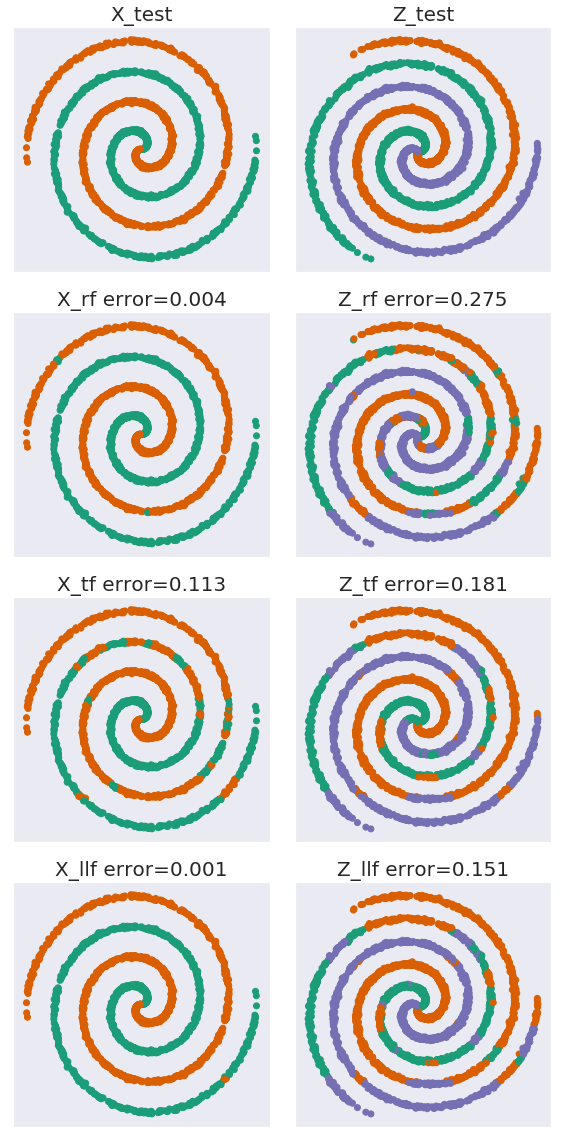

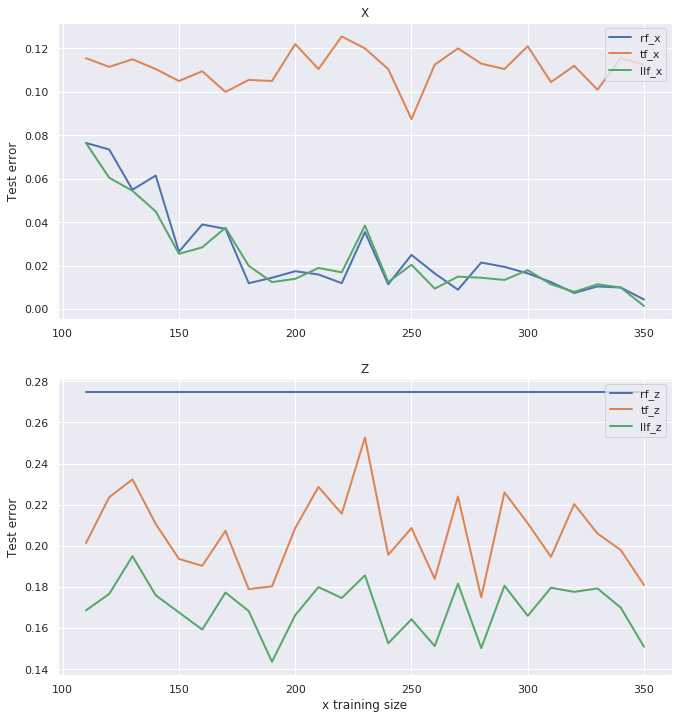

In [24]:
errs = []
axis = []
for i in range(10, 100):
    nx =10 *(i+1)
    nz = 50 # * (i+1)
    tree_size = 70
    axis.append(nx)
    e_rf0, e_rf1, e_tf0, e_tf1, e_llf0, e_llf1,\
    x, lx, z, lz, \
    l_rf0, l_rf1, l_tf0, l_tf1, l_llf0, l_llf1 = spiral_transfer(nx, nz, test_size=1000, 
                                                                     x_class=2, z_class=3,
                                                                    tree_size=tree_size)

    print("xSize:%s, zSize:%s n_estimator: %s" %(nx, nz, tree_size))
    print("forest results: rf_x %0.2f, rf_z: %.2f, tf_x: %.2f, tf_z: %.2f, llf_x:%.2f, llf_z:%.2f" 
          %(e_rf0, e_rf1, e_tf0, e_tf1, e_llf0, e_llf1))
    errs.append((e_rf0, e_rf1, e_tf0, e_tf1, e_llf0, e_llf1))
    
    if e_rf0< 0.005 or e_llf1 <0.01:
        print ('done')
        break

plotRes(x, z, lx,lz, l_rf0, l_rf1, l_tf0, l_tf1, l_llf0, l_llf1, e_rf0, e_rf1, e_tf0, e_tf1, e_llf0, e_llf1)
plotError(errs, axis=axis,xAxisLabel='x training size', )